This notebook uses methods originally developed [here](https://bitbucket.org/dhigroupinc/dhi-match-dice-research/src/master/notebooks/v2/MATCH-1678-approach-for-cleaning-judgement-data-set/analysis.ipynb?at=master#analysis.ipynb) to provide analysis surrounding inter-rater agreement in our labeled data. It provides analytics to support setting the `var_threshold` value for testing.

In [1]:
import os
from itertools import combinations
import json

import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm.auto import tqdm
from IPython.display import display, HTML
from IPython.display import Markdown as md

from dhi.dsmatch.analytics.modelevaluation import labeled_xtab, aggregate_stats_from_xtab, print_aggregate_stats
from dhi.dsmatch.util.io import read_csv
from dhi.dsmatch import local_bucket
from dhi.dsmatch.util.s3 import shared_to_s3

In [2]:
pd.set_option('display.max_columns', 200)
with open('config.yml', 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
df_test = read_csv(params['labeled_data'])
df_test.worker_email = df_test.worker_email.apply(lambda x: x.split('@')[0])
df_test.head()

,snapshot_id,year,month,day,worker_email,experience,titles,skills,overall,previous_title,current_title,profile_skills,job_skills,desired_title,job_title,job_description,description_detected_lang,resume,resume_detected_lang,description_bg_parse,resume_bg_parse,set,job_data_bg_skills,resume_data_bg_skills
0,4e98331a-c8b4-5652-bdbe-6b962afbcb58,2021,1,28,thellmuth,1.0,1.0,1.0,1.0,NaN,IT Technician & MIS Executive,Video production:: Photography:: Management in...,business development:: information technology ...,IT Technician & MIS Executive,I.T. Executive - Part-time - Business Development,<!DOCTYPE html><html><head></head><body><p sty...,en,"\r\nPlot no. 1, New Gautam Nagar, Shivaji Na...",en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""service""]","[""AC/DC Drives and Motors"", ""Adobe Photoshop"",..."
1,4e98331a-c8b4-5652-bdbe-6b962afbcb58,2021,1,28,kassidy,3.0,3.0,3.0,3.0,NaN,IT Technician & MIS Executive,Video production:: Photography:: Management in...,business development:: information technology ...,IT Technician & MIS Executive,I.T. Executive - Part-time - Business Development,<!DOCTYPE html><html><head></head><body><p sty...,en,"\r\nPlot no. 1, New Gautam Nagar, Shivaji Na...",en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""service""]","[""AC/DC Drives and Motors"", ""Adobe Photoshop"",..."
2,4e98331a-c8b4-5652-bdbe-6b962afbcb58,2021,1,28,lisa,1.0,3.0,2.0,2.0,NaN,IT Technician & MIS Executive,Video production:: Photography:: Management in...,business development:: information technology ...,IT Technician & MIS Executive,I.T. Executive - Part-time - Business Development,<!DOCTYPE html><html><head></head><body><p sty...,en,"\r\nPlot no. 1, New Gautam Nagar, Shivaji Na...",en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""service""]","[""AC/DC Drives and Motors"", ""Adobe Photoshop"",..."
3,beed9579-ada0-5310-ab94-cdf92a494bbd,2021,1,19,thellmuth,5.0,5.0,3.0,4.0,Network Engineer:: Graduate Assistant:: Intern,Network Engineer,Cisco:: Switches:: Fortinet:: Nexus:: Palo Alt...,NaN,Network Engineer,Senior Network Engineer,<p>Title: Senior Network (voice) Engineer <br ...,en,\r\nNetwork Engineer \r\nPhone: \r\nEmail ID...,en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""Analytical Skills"", ""Cisco"", ""Communication ...","[""BMC Remedy"", ""Border Gateway Protocol"", ""Bor..."
4,beed9579-ada0-5310-ab94-cdf92a494bbd,2021,1,19,kassidy,4.0,4.0,4.0,4.0,Network Engineer:: Graduate Assistant:: Intern,Network Engineer,Cisco:: Switches:: Fortinet:: Nexus:: Palo Alt...,NaN,Network Engineer,Senior Network Engineer,<p>Title: Senior Network (voice) Engineer <br ...,en,\r\nNetwork Engineer \r\nPhone: \r\nEmail ID...,en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""Analytical Skills"", ""Cisco"", ""Communication ...","[""BMC Remedy"", ""Border Gateway Protocol"", ""Bor..."


In [4]:
df_test.shape[0]

4680

In [21]:
df_pivot = df_test.pivot(index='snapshot_id', columns='worker_email', values=['skills', 'experience', 'titles', 'overall'])
df_pivot.columns = ['_'.join(tuple(map(str, t))) for t in df_pivot.columns.values]
# df_pivot['n_entries'] = df_pivot.notnull().sum(axis=1)
df_pivot.head()

,skills_kassidy,skills_lisa,skills_thellmuth,experience_kassidy,experience_lisa,experience_thellmuth,titles_kassidy,titles_lisa,titles_thellmuth,overall_kassidy,overall_lisa,overall_thellmuth
snapshot_id,,,,,,,,,,,,
001b7999-c730-536d-aa35-21126da0c869,5.0,5.0,NaN,5.0,5.0,NaN,5.0,5.0,NaN,5.0,5.0,NaN
0030610f-a33a-5cd4-851a-397af35354d3,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
00313010-23e5-5bae-a1a9-6868a15a79fa,2.0,4.0,3.0,3.0,5.0,4.0,3.0,5.0,4.0,2.0,4.0,3.0
003dddce-4a96-56ae-b23f-8544364e9ae7,5.0,4.0,5.0,4.0,4.0,5.0,3.0,4.0,5.0,4.0,4.0,5.0
004e641d-b035-5f7b-bfaf-3c910f299389,2.0,5.0,4.0,3.0,5.0,5.0,4.0,5.0,4.0,2.0,5.0,4.0


In [22]:
rowcols = np.arange(1,6)
for domain in ['skills', 'experience', 'titles', 'overall']:
    display(md(f'### {domain}'))
    cols = [c for c in df_pivot if c.find(domain + '_')>=0]
    df_ = df_pivot[cols]

    for (pred_col, labeled_col) in combinations(df_.columns, 2):
        df_xtab = labeled_xtab(df_, pred_col=pred_col, labeled_col=labeled_col, rownames=rowcols, colnames=rowcols)
        d_stats = aggregate_stats_from_xtab(df_xtab)
        print_aggregate_stats(d_stats)
        display(HTML(df_xtab.to_html()))

### skills

Total number of records: 1267
Total exact matches: 426
Percent exact: 33.6%
Percent one-half 1 off: 56.6%
Percent Gaussian rolloff: 63.9%


skills_lisa,1.0,2.0,3.0,4.0,5.0
skills_kassidy,,,,,
1.0,28,13,10,4,2
2.0,56,51,56,48,15
3.0,35,45,59,95,77
4.0,16,25,68,129,187
5.0,1,2,23,63,159


Total number of records: 1237
Total exact matches: 519
Percent exact: 42.0%
Percent one-half 1 off: 65.6%
Percent Gaussian rolloff: 71.9%


skills_thellmuth,1.0,2.0,3.0,4.0,5.0
skills_kassidy,,,,,
1.0,21,14,18,3,0
2.0,22,72,94,29,4
3.0,10,51,139,85,14
4.0,5,22,134,197,62
5.0,1,1,26,123,90


Total number of records: 1464
Total exact matches: 538
Percent exact: 36.7%
Percent one-half 1 off: 60.9%
Percent Gaussian rolloff: 67.9%


skills_thellmuth,1.0,2.0,3.0,4.0,5.0
skills_lisa,,,,,
1.0,49,60,44,5,0
2.0,11,41,77,17,2
3.0,7,42,123,59,11
4.0,4,26,148,171,45
5.0,2,10,90,266,154


### experience

Total number of records: 1265
Total exact matches: 443
Percent exact: 35.0%
Percent one-half 1 off: 57.1%
Percent Gaussian rolloff: 64.1%


experience_lisa,1.0,2.0,3.0,4.0,5.0
experience_kassidy,,,,,
1.0,61,22,10,6,6
2.0,56,65,57,51,19
3.0,35,46,56,72,57
4.0,10,40,55,101,169
5.0,3,6,20,82,160


Total number of records: 1235
Total exact matches: 510
Percent exact: 41.3%
Percent one-half 1 off: 63.7%
Percent Gaussian rolloff: 70.1%


experience_thellmuth,1.0,2.0,3.0,4.0,5.0
experience_kassidy,,,,,
1.0,30,30,25,9,3
2.0,25,77,91,48,8
3.0,12,38,108,75,27
4.0,3,17,77,144,123
5.0,2,0,17,95,151


Total number of records: 1464
Total exact matches: 585
Percent exact: 40.0%
Percent one-half 1 off: 62.4%
Percent Gaussian rolloff: 68.9%


experience_thellmuth,1.0,2.0,3.0,4.0,5.0
experience_lisa,,,,,
1.0,64,74,47,9,0
2.0,15,50,82,38,7
3.0,6,39,87,66,30
4.0,2,17,95,142,98
5.0,2,11,53,188,242


### titles

Total number of records: 1264
Total exact matches: 480
Percent exact: 38.0%
Percent one-half 1 off: 57.8%
Percent Gaussian rolloff: 64.3%


titles_lisa,1.0,2.0,3.0,4.0,5.0
titles_kassidy,,,,,
1.0,79,26,16,11,2
2.0,64,38,41,36,17
3.0,36,44,57,68,58
4.0,23,35,44,98,143
5.0,6,9,35,70,208


Total number of records: 1236
Total exact matches: 468
Percent exact: 37.9%
Percent one-half 1 off: 62.5%
Percent Gaussian rolloff: 69.3%


titles_thellmuth,1.0,2.0,3.0,4.0,5.0
titles_kassidy,,,,,
1.0,50,45,33,5,1
2.0,28,71,83,16,1
3.0,6,46,108,83,5
4.0,8,25,112,147,42
5.0,1,7,50,171,92


Total number of records: 1459
Total exact matches: 537
Percent exact: 36.8%
Percent one-half 1 off: 59.7%
Percent Gaussian rolloff: 66.6%


titles_thellmuth,1.0,2.0,3.0,4.0,5.0
titles_lisa,,,,,
1.0,84,94,55,13,0
2.0,11,47,75,20,1
3.0,9,39,103,49,12
4.0,4,23,124,172,16
5.0,3,15,99,260,131


### overall

Total number of records: 1265
Total exact matches: 449
Percent exact: 35.5%
Percent one-half 1 off: 57.5%
Percent Gaussian rolloff: 64.3%


overall_lisa,1.0,2.0,3.0,4.0,5.0
overall_kassidy,,,,,
1.0,53,28,9,8,5
2.0,57,69,73,57,20
3.0,22,53,68,68,57
4.0,14,39,49,114,144
5.0,0,8,21,84,145


Total number of records: 1233
Total exact matches: 525
Percent exact: 42.6%
Percent one-half 1 off: 65.3%
Percent Gaussian rolloff: 71.6%


overall_thellmuth,1.0,2.0,3.0,4.0,5.0
overall_kassidy,,,,,
1.0,33,33,23,7,1
2.0,24,108,109,32,3
3.0,10,50,105,75,12
4.0,5,21,108,179,45
5.0,0,2,31,117,100


Total number of records: 1463
Total exact matches: 559
Percent exact: 38.2%
Percent one-half 1 off: 61.4%
Percent Gaussian rolloff: 68.3%


overall_thellmuth,1.0,2.0,3.0,4.0,5.0
overall_lisa,,,,,
1.0,60,70,39,3,0
2.0,16,76,81,30,0
3.0,11,54,114,66,13
4.0,2,33,118,176,52
5.0,2,9,83,222,133


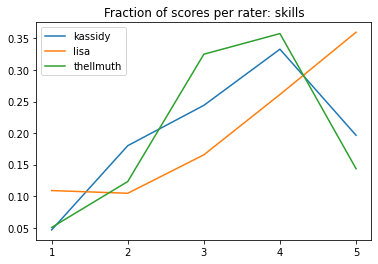

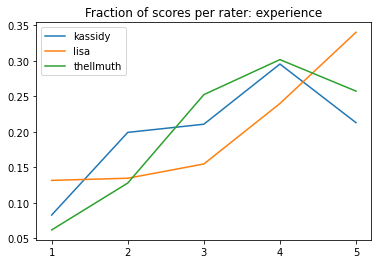

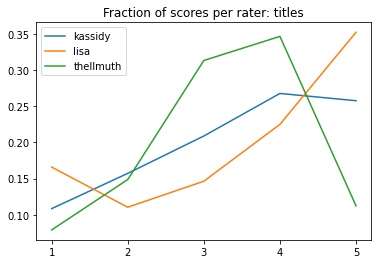

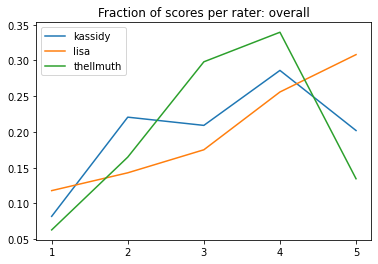

In [23]:
for domain in ['skills', 'experience', 'titles', 'overall']:
    cols = [c for c in df_pivot if c.find(domain + '_')>=0]
    df_ = df_pivot[cols]
    fig, ax = plt.subplots()
    for c in df_.columns:
        ax.plot(df_[c].value_counts(normalize=True).sort_index(), label=c.split('_')[-1].split('@')[0])

    ax.legend()
    ax.set_title(f'Fraction of scores per rater: {domain}');
    ax.set_xticks(range(1,6));

In [27]:
df_ = df_pivot[cols]
# # Rounding required for value_counts next to work correctly
df_var = (df_.dropna().var(axis=1)).apply(lambda x: np.round(x, 3))
df_var_summary = df_var.value_counts().sort_index().to_frame('n')
df_var_summary.reset_index(inplace=True)
df_var_summary['fraction'] = df_var_summary['n'] / df_var.shape[0]
df_var_summary.rename(columns={'index': 'var'}, inplace=True)
df_var_summary['cdf'] = df_var_summary.fraction.cumsum()

# df_var_summary['description'] = ['Same', 
#              '2 Same, 1 1-away', 
#              '+1,middle,-1 (e.g., 2,3,4)',
#              '2 Same, 1 2-away, (e.g., 2,2,4)',
#              '2 1-away, 1 2-away (e.g., 4,3,1)',
#              '2 Same, 1 3-away']
df_var_summary.sort_values(by='var')

,var,n,fraction,cdf
0,0.000,203,0.180444,0.180444
1,0.333,561,0.498667,0.679111
2,1.000,174,0.154667,0.833778
3,1.333,115,0.102222,0.936000
4,2.333,58,0.051556,0.987556
5,3.000,8,0.007111,0.994667
6,4.000,2,0.001778,0.996444
7,4.333,3,0.002667,0.999111
8,5.333,1,0.000889,1.000000


In [14]:
df_keepers = df_pivot.loc[df_var[df_var < 1.].index]
df_keepers.head()

,skills_kassidy,skills_lisa,skills_thellmuth,experience_kassidy,experience_lisa,experience_thellmuth,titles_kassidy,titles_lisa,titles_thellmuth,overall_kassidy,overall_lisa,overall_thellmuth
snapshot_id,,,,,,,,,,,,
0030610f-a33a-5cd4-851a-397af35354d3,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
003dddce-4a96-56ae-b23f-8544364e9ae7,5.0,4.0,5.0,4.0,4.0,5.0,3.0,4.0,5.0,4.0,4.0,5.0
00734cba-aeee-5d10-9add-142c3fc7d25a,4.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0
0076d812-2ecb-5d45-8a3c-806f01b34c2d,3.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0
010d401d-295d-56f6-883d-188b9d2e82fb,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0


In [15]:
rowcols = np.arange(1,6)
for domain in ['overall']:
    display(md(f'### {domain}'))
    cols = [c for c in df_keepers if c.find(domain + '_')>=0]
    df_ = df_keepers[cols]

    for (pred_col, labeled_col) in combinations(df_.columns, 2):
        df_xtab = labeled_xtab(df_, pred_col=pred_col, labeled_col=labeled_col, rownames=rowcols, colnames=rowcols)
        d_stats = aggregate_stats_from_xtab(df_xtab)
        print_aggregate_stats(d_stats)
        display(HTML(df_xtab.to_html()))

### overall

Total number of records: 764
Total exact matches: 363
Percent exact: 47.5%
Percent one-half 1 off: 73.8%
Percent Gaussian rolloff: 79.3%


overall_lisa,1.0,2.0,3.0,4.0,5.0
overall_kassidy,,,,,
1.0,33,17,0,0,0
2.0,40,57,57,0,0
3.0,0,38,53,46,0
4.0,0,0,39,99,102
5.0,0,0,0,62,121


Total number of records: 764
Total exact matches: 421
Percent exact: 55.1%
Percent one-half 1 off: 77.6%
Percent Gaussian rolloff: 82.3%


overall_thellmuth,1.0,2.0,3.0,4.0,5.0
overall_kassidy,,,,,
1.0,26,24,0,0,0
2.0,16,86,52,0,0
3.0,0,27,72,38,0
4.0,0,0,48,149,43
5.0,0,0,0,95,88


Total number of records: 764
Total exact matches: 386
Percent exact: 50.5%
Percent one-half 1 off: 75.3%
Percent Gaussian rolloff: 80.5%


overall_thellmuth,1.0,2.0,3.0,4.0,5.0
overall_lisa,,,,,
1.0,31,42,0,0,0
2.0,11,60,41,0,0
3.0,0,35,82,32,0
4.0,0,0,49,120,38
5.0,0,0,0,130,93


In [16]:
df_ = df_var[df_var < 1].index.to_frame()
df_.reset_index(drop=True, inplace=True)
df = pd.merge(df_test, df_)
df.head()

,snapshot_id,year,month,day,worker_email,experience,titles,skills,overall,previous_title,current_title,profile_skills,job_skills,desired_title,job_title,job_description,description_detected_lang,resume,resume_detected_lang,description_bg_parse,resume_bg_parse,set,job_data_bg_skills,resume_data_bg_skills
0,beed9579-ada0-5310-ab94-cdf92a494bbd,2021,1,19,thellmuth,5.0,5.0,3.0,4.0,Network Engineer:: Graduate Assistant:: Intern,Network Engineer,Cisco:: Switches:: Fortinet:: Nexus:: Palo Alt...,NaN,Network Engineer,Senior Network Engineer,<p>Title: Senior Network (voice) Engineer <br ...,en,\r\nNetwork Engineer \r\nPhone: \r\nEmail ID...,en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""Analytical Skills"", ""Cisco"", ""Communication ...","[""BMC Remedy"", ""Border Gateway Protocol"", ""Bor..."
1,beed9579-ada0-5310-ab94-cdf92a494bbd,2021,1,19,kassidy,4.0,4.0,4.0,4.0,Network Engineer:: Graduate Assistant:: Intern,Network Engineer,Cisco:: Switches:: Fortinet:: Nexus:: Palo Alt...,NaN,Network Engineer,Senior Network Engineer,<p>Title: Senior Network (voice) Engineer <br ...,en,\r\nNetwork Engineer \r\nPhone: \r\nEmail ID...,en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""Analytical Skills"", ""Cisco"", ""Communication ...","[""BMC Remedy"", ""Border Gateway Protocol"", ""Bor..."
2,beed9579-ada0-5310-ab94-cdf92a494bbd,2021,1,19,lisa,4.0,5.0,4.0,4.0,Network Engineer:: Graduate Assistant:: Intern,Network Engineer,Cisco:: Switches:: Fortinet:: Nexus:: Palo Alt...,NaN,Network Engineer,Senior Network Engineer,<p>Title: Senior Network (voice) Engineer <br ...,en,\r\nNetwork Engineer \r\nPhone: \r\nEmail ID...,en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""Analytical Skills"", ""Cisco"", ""Communication ...","[""BMC Remedy"", ""Border Gateway Protocol"", ""Bor..."
3,2eea1437-73cd-56aa-acb9-4c48985651e3,2021,1,18,thellmuth,1.0,1.0,2.0,1.0,NaN,NaN,.NET:: .NET Core:: C#:: CSS:: Communication sk...,oracle weblogic:: eclipse ide integrated:: git...,Junior Software Developer,Java Developer,<!DOCTYPE html><html><head></head><body><p><st...,en,"139 Hilton Drive, South Windsor \r\n ...",en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""508 Compliance Testing"", ""Automated Testing""...","[""Adobe Photoshop"", ""Bilingual"", ""Communicatio..."
4,2eea1437-73cd-56aa-acb9-4c48985651e3,2021,1,18,lisa,2.0,1.0,3.0,2.0,NaN,NaN,.NET:: .NET Core:: C#:: CSS:: Communication sk...,oracle weblogic:: eclipse ide integrated:: git...,Junior Software Developer,Java Developer,<!DOCTYPE html><html><head></head><body><p><st...,en,"139 Hilton Drive, South Windsor \r\n ...",en,"{""status"": true, ""status_code"": ""OK"", ""request...","{""status"": true, ""statusCode"": ""OK"", ""requestI...",test,"[""508 Compliance Testing"", ""Automated Testing""...","[""Adobe Photoshop"", ""Bilingual"", ""Communicatio..."
